# Helper Function

In [189]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

def walk_through_dir(dir_path):
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(
            f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'."
        )

def count_images(directory, classes):
    counts = []
    total_count = 0  # Variable to store the total count for all classes
    for emotion_class in classes:
        class_path = os.path.join(directory, emotion_class)
        num_images = len(os.listdir(class_path))
        counts.append(num_images)
        total_count += num_images
    counts.append(total_count)  # Append the total count at the end
    return counts

def plot_emotion_distribution(train_dir, test_dir, classes, colors, labels):
    train_counts = count_images(train_dir, classes)
    test_counts = count_images(test_dir, classes)

    fig, ax = plt.subplots(figsize=(10, 6))

    bar_width = 0.35
    index = np.arange(len(classes) + 1)  # Increase the length by 1 for the total count bar

    for i, (count, color) in enumerate(zip([train_counts, test_counts], colors)):
        ax.bar(index + i * bar_width, count, bar_width, label=f'{["Train", "Test"][i]}')

    for i, count in enumerate(train_counts):
        ax.text(i, count + 10, str(count), ha='center', va='bottom')

    for i, count in enumerate(test_counts):
        ax.text(i + bar_width, count + 10, str(count), ha='center', va='bottom')

    ax.set_xlabel('Emotion Classes')
    ax.set_ylabel('Number of Images')
    ax.set_title('Distribution of Images in Train and Test Sets')
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(labels + ['Total'])  # Add 'Total' label to the x-axis
    ax.legend()

    plt.show()

# Import the Data

In [190]:
walk_through_dir("D:\Code\py_code\Convolutional-Neural-Network\data")

There are 2 directories and 0 images in 'D:\Code\py_code\Convolutional-Neural-Network\data'.
There are 3 directories and 0 images in 'D:\Code\py_code\Convolutional-Neural-Network\data\test'.
There are 0 directories and 213 images in 'D:\Code\py_code\Convolutional-Neural-Network\data\test\angry'.
There are 0 directories and 207 images in 'D:\Code\py_code\Convolutional-Neural-Network\data\test\happy'.
There are 0 directories and 149 images in 'D:\Code\py_code\Convolutional-Neural-Network\data\test\sad'.
There are 3 directories and 0 images in 'D:\Code\py_code\Convolutional-Neural-Network\data\train'.
There are 0 directories and 850 images in 'D:\Code\py_code\Convolutional-Neural-Network\data\train\angry'.
There are 0 directories and 830 images in 'D:\Code\py_code\Convolutional-Neural-Network\data\train\happy'.
There are 0 directories and 598 images in 'D:\Code\py_code\Convolutional-Neural-Network\data\train\sad'.


In [191]:
train_dir = r"D:\Code\py_code\Convolutional-Neural-Network\data\train"
test_dir = r"D:\Code\py_code\Convolutional-Neural-Network\data\test"

### **Dataset Visualization**

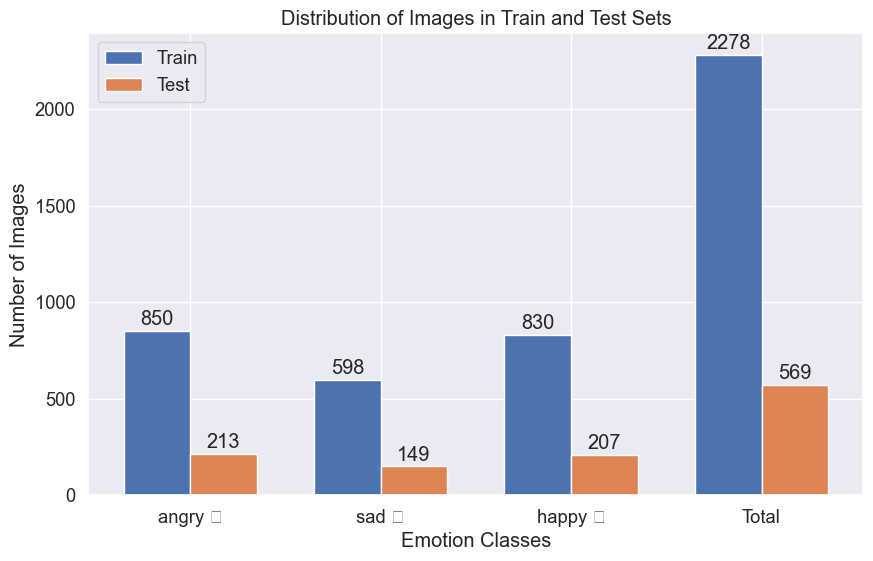

In [192]:
emotion_classes = ['angry', 'sad', 'happy']
emotion_labels = ['angry 😡', 'sad 😭', 'happy 😁']

plot_emotion_distribution(train_dir, test_dir, emotion_classes, colors=['red', 'blue'],labels=emotion_labels)

### **Hyperparameters for the Next Step**

In [193]:
IMG_HEIGHT = 128
IMG_WIDTH = 128
BATCH_SIZE = 32
EPOCHS = 10
FINE_TUNING_EPOCHS = 10
LR = 1e-3
FINE_TUNING_LR = 1e-5
NUM_CLASSES = 3
EARLY_STOPPING_CRITERIA=3

# Reproducibility Settings

In [194]:
import tensorflow as tf

tf.keras.utils.set_random_seed(42)
np.random.seed(42)
tf.random.set_seed(42)
session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1
)
tf.compat.v1.set_random_seed(42)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

# Preprocessing the Data

In [195]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

preprocess_fun = tf.keras.applications.inception_v3.preprocess_input

train_datagen = ImageDataGenerator(
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.05,
    rotation_range=20,
    rescale=1./255,
    # preprocessing_function=preprocess_fun,
    validation_split=0.2
)
test_datagen = ImageDataGenerator(rescale=1./255,
                                #   preprocessing_function=preprocess_fun,
                                  )

train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=True,
    color_mode="rgb",
    class_mode="categorical",
    subset="training",  
    seed=42
)

validation_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=False,
    color_mode="rgb",
    class_mode="categorical",
    subset="validation",  
    seed=42
)

test_generator = test_datagen.flow_from_directory(directory=test_dir,
                                                   target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                   batch_size=BATCH_SIZE,
                                                   shuffle=False,
                                                   color_mode="rgb",
                                                   class_mode="categorical",
                                                   seed=42
                                                  )

Found 1823 images belonging to 3 classes.
Found 455 images belonging to 3 classes.
Found 569 images belonging to 3 classes.


# Create Model

In [196]:
def feature_extractor(inputs):
    feature_extractor = tf.keras.applications.inception_v3.InceptionV3(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
                                                          include_top=False,
                                                          weights="imagenet")(inputs)

    return feature_extractor

def classifier(inputs):
    x = tf.keras.layers.GlobalMaxPooling2D()(inputs)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(256, activation="relu")(x)
    # x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(256, activation="relu")(x)
    x = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax", name="classification")(x)

    return x

def final_model(inputs):
    densenet_feature_extractor = feature_extractor(inputs)
    classification_output = classifier(densenet_feature_extractor)

    return classification_output

def define_compile_model():
    inputs = tf.keras.layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    classification_output = final_model(inputs)
    model = tf.keras.Model(inputs=inputs, outputs=classification_output)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

### **Model Summary**

In [197]:
model = define_compile_model()

# Feezing the feature extraction layers
model.layers[1].trainable = False

model.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 128, 128, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, 2, 2, 2048)        21802784  
                                                                 
 global_max_pooling2d_10 (Gl  (None, 2048)             0         
 obalMaxPooling2D)                                               
                                                                 
 flatten_10 (Flatten)        (None, 2048)              0         
                                                                 
 dense_19 (Dense)            (None, 256)               524544    
                                                                 
 dense_20 (Dense)            (None, 256)               65792     
                                                          

# Training the Model

In [198]:
earlyStoppingCallback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                         patience=EARLY_STOPPING_CRITERIA,
                                                         verbose= 1 ,
                                                         restore_best_weights=True
                                                        )

history = model.fit(x = train_generator,
                    epochs = EPOCHS,
                    validation_data = validation_generator,
                    callbacks= [earlyStoppingCallback])

history = pd.DataFrame(history.history)

Epoch 1/10


KeyboardInterrupt: 

### **Fine Tuning**

In [ ]:
# Un-Freezing the feature extraction layers for fine tuning
model.layers[1].trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(FINE_TUNING_LR), #lower learning rate
                loss='categorical_crossentropy',
                metrics = ['accuracy'])

history_ = model.fit(x = train_generator,epochs = FINE_TUNING_EPOCHS ,validation_data = validation_generator, callbacks= [earlyStoppingCallback])

Epoch 1/10
57/57 [==============================] - 11s 130ms/step - loss: 0.5360 - accuracy: 0.7674 - val_loss: 0.7301 - val_accuracy: 0.6813
Epoch 2/10
57/57 [==============================] - 6s 109ms/step - loss: 0.5221 - accuracy: 0.7800 - val_loss: 0.7003 - val_accuracy: 0.7011
Epoch 3/10
57/57 [==============================] - 6s 112ms/step - loss: 0.5395 - accuracy: 0.7647 - val_loss: 0.7062 - val_accuracy: 0.6945
Epoch 4/10
57/57 [==============================] - 6s 108ms/step - loss: 0.5360 - accuracy: 0.7652 - val_loss: 0.7190 - val_accuracy: 0.6989
Epoch 5/10
57/57 [==============================] - 6s 109ms/step - loss: 0.5354 - accuracy: 0.7729 - val_loss: 0.7286 - val_accuracy: 0.6747
Epoch 5: early stopping


In [ ]:
history = history._append(pd.DataFrame(history_.history) , ignore_index=True)

In [ ]:
preds_ts = model.predict(test_generator)
y_preds_ts = np.argmax(preds_ts , axis=1)
y_test = np.array(test_generator.labels)

preds_tr = model.predict(train_generator)
y_preds_tr = np.argmax(preds_tr , axis=1)
y_train = np.array(train_generator.labels)

preds_vl = model.predict(validation_generator)
y_preds_vl = np.argmax(preds_vl , axis=1)
y_validation = np.array(validation_generator.labels)

15/15 [==============================] - 1s 89ms/step


# Model Evaluation

In [ ]:
from sklearn.metrics import confusion_matrix , classification_report, accuracy_score

### **Train Report**

In [ ]:
loss, accuracy = model.evaluate(train_generator)
print(f" Training Loss: {loss}, Training Accuracy: {accuracy}")

57/57 [==============================] - 5s 95ms/step - loss: 0.5357 - accuracy: 0.7658
 Training Loss: 0.535656750202179, Training Accuracy: 0.7657707333564758


### **Test Report**

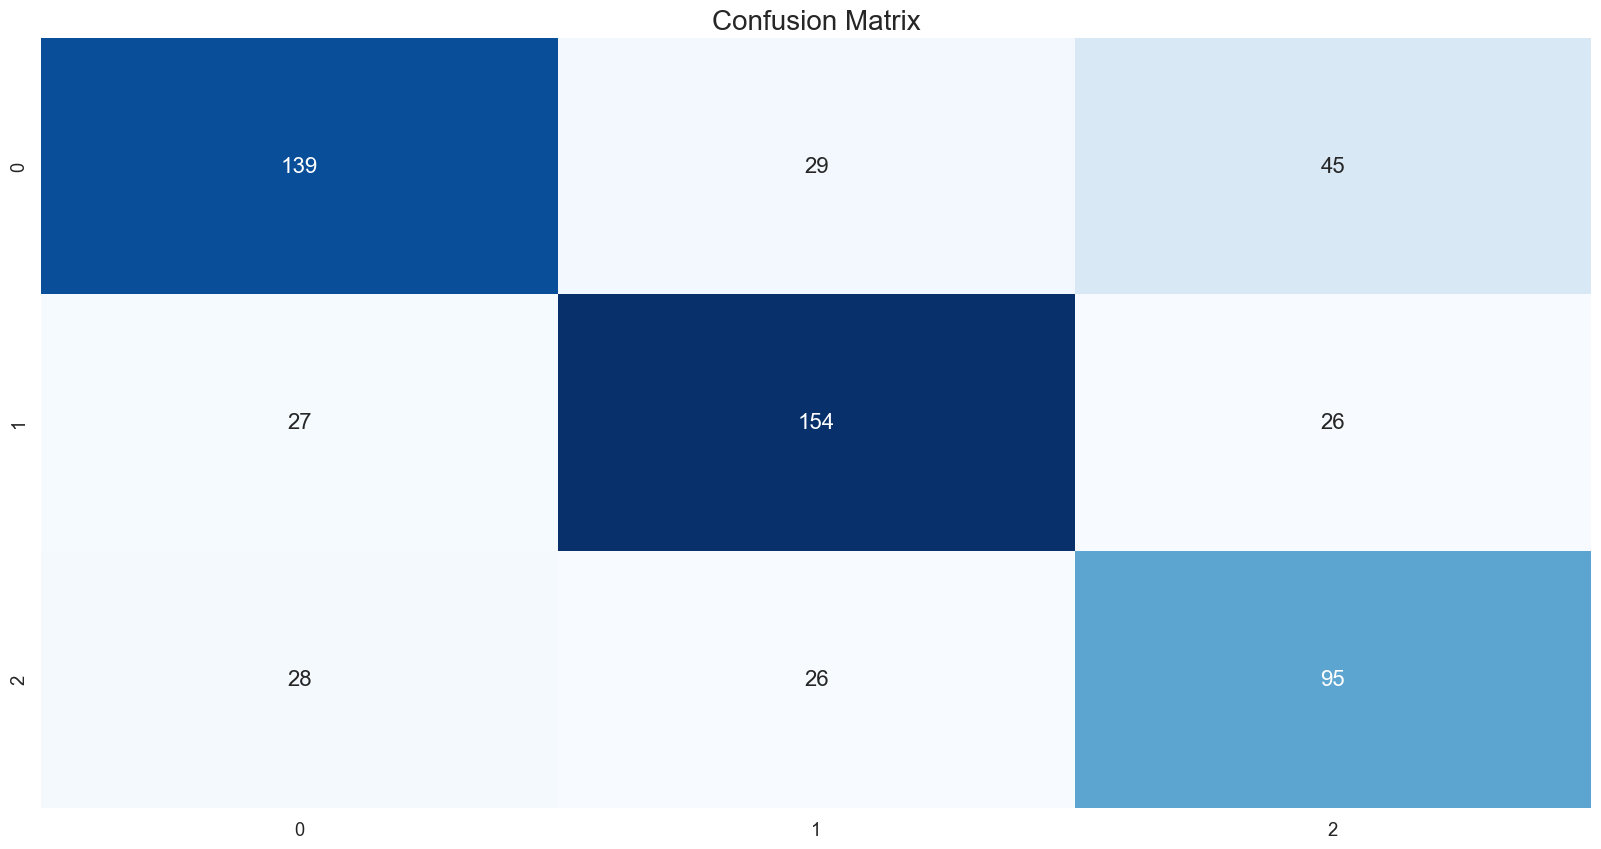

In [ ]:
cm_test = confusion_matrix(y_test , y_preds_ts)
cm_ts = pd.DataFrame(cm_test, columns=emotion_classes, index = emotion_classes)
cm_ts.index.name = 'Actual'
cm_ts.columns.name = 'Predicted'
plt.figure(figsize = (20,10))
plt.title('Confusion Matrix', fontsize = 20)
sns.set(font_scale=1.2)
ax = sns.heatmap(cm_test, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')

In [ ]:
model.evaluate(test_generator)

18/18 [==============================] - 1s 39ms/step - loss: 0.7372 - accuracy: 0.6819


[0.7372386455535889, 0.6818980574607849]

In [ ]:
print(classification_report(y_test , y_preds_ts))
test_report = classification_report(y_test , y_preds_ts, output_dict=True)
print(f"Test accuracy : {test_report['accuracy']}")

              precision    recall  f1-score   support

           0       0.72      0.65      0.68       213
           1       0.74      0.74      0.74       207
           2       0.57      0.64      0.60       149

    accuracy                           0.68       569
   macro avg       0.68      0.68      0.68       569
weighted avg       0.69      0.68      0.68       569

Test accuracy : 0.6818980667838312


### **Validation Report**

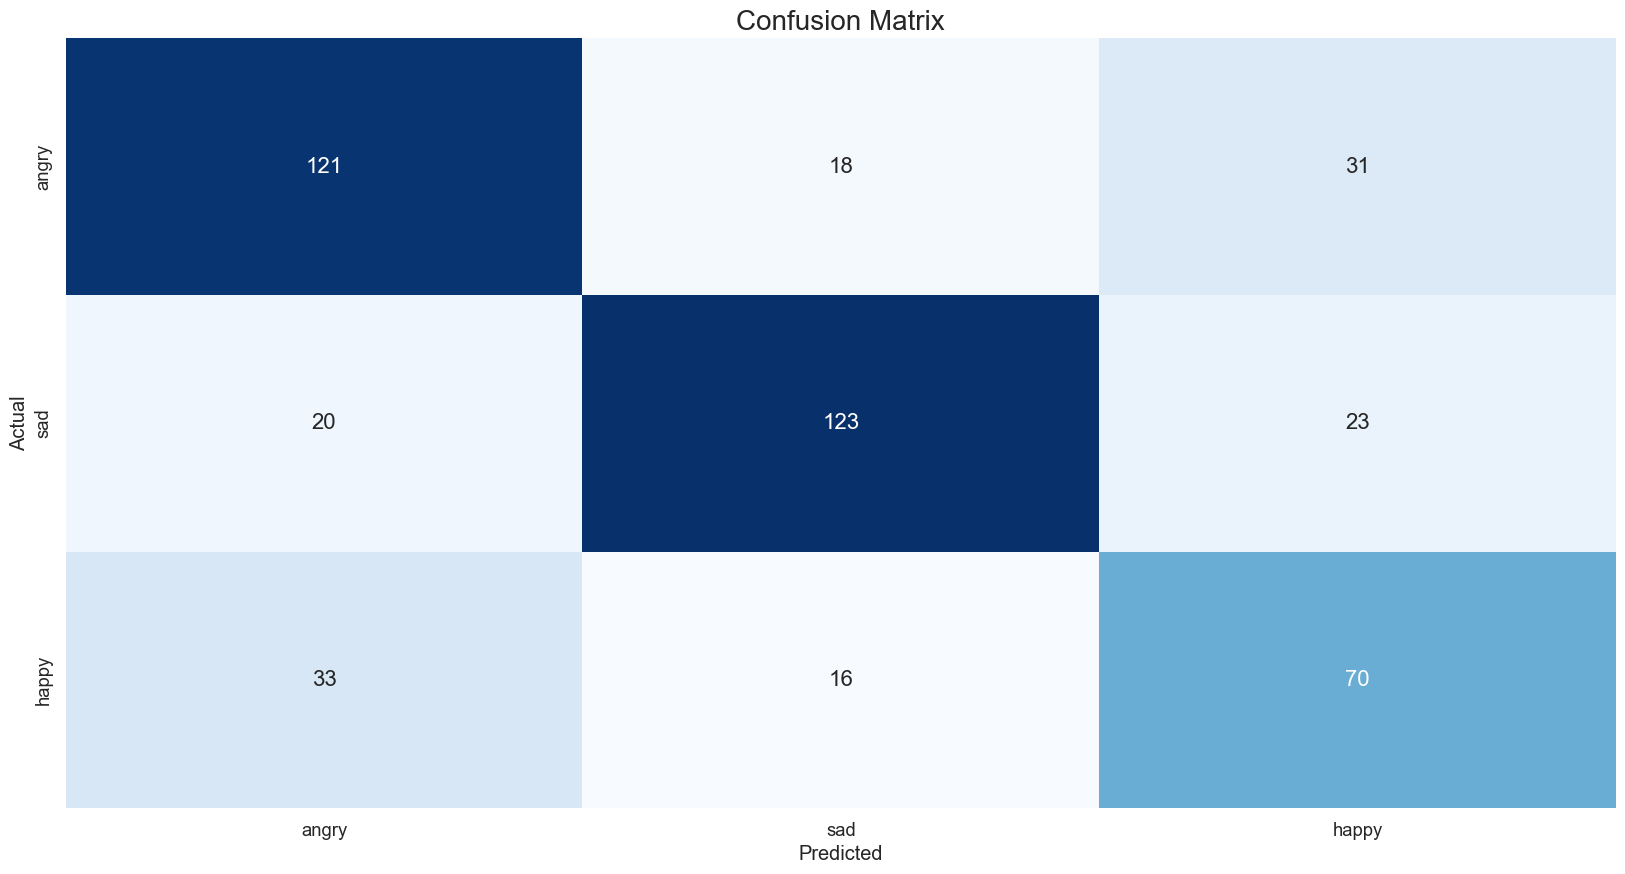

In [ ]:
cm_validation = confusion_matrix(y_validation , y_preds_vl)
cm_vl = pd.DataFrame(cm_validation, columns=emotion_classes, index = emotion_classes)
cm_vl.index.name = 'Actual'
cm_vl.columns.name = 'Predicted'
plt.figure(figsize = (20,10))
plt.title('Confusion Matrix', fontsize = 20)
sns.set(font_scale=1.2)
ax = sns.heatmap(cm_vl, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')

In [ ]:
print(classification_report(y_validation , y_preds_vl))
validation_report = classification_report(y_validation , y_preds_vl, output_dict=True)
print(f"Validation accuracy : {validation_report['accuracy']}")

              precision    recall  f1-score   support

           0       0.70      0.71      0.70       170
           1       0.78      0.74      0.76       166
           2       0.56      0.59      0.58       119

    accuracy                           0.69       455
   macro avg       0.68      0.68      0.68       455
weighted avg       0.69      0.69      0.69       455

Validation accuracy : 0.6901098901098901


# Parameter and Result 

In [ ]:
parameters = {
    'IMG_HEIGHT': IMG_HEIGHT,
    'IMG_WIDTH': IMG_WIDTH,
    'BATCH_SIZE': BATCH_SIZE,
    'EPOCHS': EPOCHS,
    'FINE_TUNING_EPOCHS': FINE_TUNING_EPOCHS,
    'LR': LR,
    'FINE_TUNING_LR': FINE_TUNING_LR,
    'NUM_CLASSES': NUM_CLASSES,
    'EARLY_STOPPING_CRITERIA': EARLY_STOPPING_CRITERIA
}

result = {
    "TRAINING LOSS": loss,
    "VALIDATION ACCURACY": validation_report['accuracy'],
    "TEST ACCURACY": test_report['accuracy'],
    "F1 SCORE": test_report['macro avg']['f1-score']
}

data = {**parameters, **result}
df = pd.DataFrame(data, index=[0])
filename = f"output_{parameters['IMG_HEIGHT']}_{parameters['IMG_WIDTH']}_{parameters['BATCH_SIZE']}_{parameters['EPOCHS']}.xlsx"
df.to_excel(filename, index=False)